In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import tqdm
import fastapi
import uvicorn
import mlflow
import dotenv

# Show versions
print("📦 Versions:")
print(f"Pandas: {pd.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print(f"Seaborn: {sns.__version__}")
print(f"scikit-learn: {sklearn.__version__}")
print(f"TQDM: {tqdm.__version__}")
print(f"FastAPI: {fastapi.__version__}")
print(f"Uvicorn: {uvicorn.__version__}")
print(f"MLflow: {mlflow.__version__}")

📦 Versions:
Pandas: 2.2.3
Numpy: 2.0.2
Matplotlib: 3.10.0
Seaborn: 0.13.2
scikit-learn: 1.6.1
TQDM: 4.67.1
FastAPI: 0.116.1
Uvicorn: 0.35.0
MLflow: 3.1.1


2025/07/21 19:24:47 INFO mlflow.tracking.fluent: Experiment with name 'Iris_RandomForest_Experiment' does not exist. Creating a new experiment.


Loading existing model checkpoint...


Training epochs:   0%|          | 0/5 [00:00<?, ?it/s]

2025/07/21 19:24:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch 1/5 - Accuracy: 1.0000
New best model saved with accuracy: 1.0000


2025/07/21 19:25:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 2/5 - Accuracy: 1.0000
Epoch 3/5 - Accuracy: 1.0000
Epoch 4/5 - Accuracy: 1.0000
Epoch 5/5 - Accuracy: 1.0000


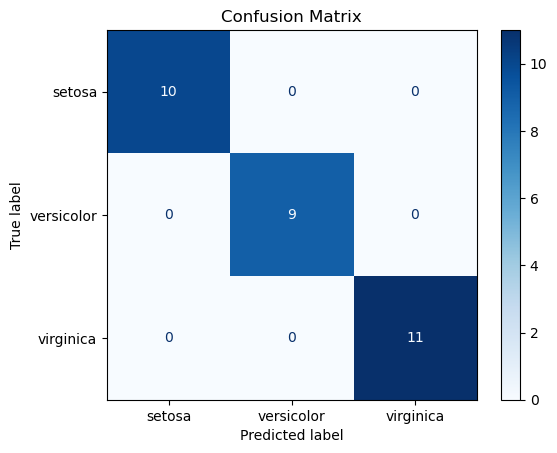

In [3]:
import mlflow
import mlflow.sklearn
import csv
from datetime import datetime

# Clear: paths and constants
MODEL_PATH = "best_model.pkl"
TRAINING_LOG_CSV = "training_log.csv"
CONF_MATRIX_PNG = "confusion_matrix.png"

# Load Iris data (same as before)
iris = load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load existing model or create new
if os.path.exists(MODEL_PATH):
    print("Loading existing model checkpoint...")
    model = joblib.load(MODEL_PATH)
else:
    print("No checkpoint found, creating a new model...")
    model = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize MLflow experiment
mlflow.set_experiment("Iris_RandomForest_Experiment")

# Read old best accuracy from CSV log, if any
def read_best_acc(csv_path):
    best = 0.0
    if os.path.exists(csv_path):
        with open(csv_path, "r") as f:
            reader = csv.DictReader(f)
            for row in reader:
                acc = float(row["accuracy"])
                if acc > best:
                    best = acc
    return best

best_acc = read_best_acc(TRAINING_LOG_CSV)

# Start MLflow run
with mlflow.start_run(run_name=f"Run_{datetime.now().strftime('%Y%m%d_%H%M%S')}") as run:

    epochs = 5
    for epoch in tqdm(range(epochs), desc="Training epochs"):

        # Train model (retrain fully here)
        model.fit(X_train, y_train)

        # Predict & accuracy
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"Epoch {epoch+1}/{epochs} - Accuracy: {acc:.4f}")

        # Log metrics and parameters to MLflow
        mlflow.log_param("n_estimators", model.n_estimators)
        mlflow.log_metric("accuracy", acc, step=epoch+1)

        # Save model if better accuracy
        if acc > best_acc:
            best_acc = acc
            joblib.dump(model, MODEL_PATH)
            print(f"New best model saved with accuracy: {best_acc:.4f}")
            mlflow.sklearn.log_model(model, "best_model")

    # Confusion Matrix plot
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.savefig(CONF_MATRIX_PNG)
    plt.show()

    # Log plot as artifact
    mlflow.log_artifact(CONF_MATRIX_PNG)

    # Append current run info to CSV log file (training_log.csv)
    file_exists = os.path.exists(TRAINING_LOG_CSV)
    with open(TRAINING_LOG_CSV, mode="a", newline="") as csvfile:
        fieldnames = ["timestamp", "accuracy", "n_estimators", "run_id"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        if not file_exists:
            writer.writeheader()
        writer.writerow({
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "accuracy": best_acc,
            "n_estimators": model.n_estimators,
            "run_id": run.info.run_id
        })